In [ ]:
from canns.models.basic import HierarchicalNetwork

# Create hierarchical network with 5 modules
hierarchical_net = HierarchicalNetwork(
    num_module=5,        # Number of grid modules (different scales)
    num_place=30,        # Place cells per dimension (30x30 = 900 total)
    spacing_min=2.0,     # Smallest grid spacing
    spacing_max=5.0,     # Largest grid spacing
    module_angle=0.0     # Base orientation angle
)

<OpenLoopNavigationTask>Generating Task data: 100%|██████████| 1000000/1000000 [00:00<00:00, 1468708.52it/s]


Trajectory: 1000000 steps
Environment: 5.0m x 5.0m


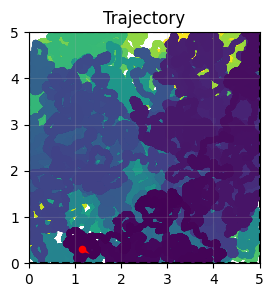

In [14]:
import brainpy.math as bm
import numpy as np
from canns.models.basic import HierarchicalNetwork
from canns.task.open_loop_navigation import OpenLoopNavigationTask

# Setup environment
bm.set_dt(0.05)

# Create navigation task (5m x 5m environment)
task = OpenLoopNavigationTask(
    width=5.0,           # Environment width (meters)
    height=5.0,          # Environment height (meters)
    speed_mean=0.04,     # Mean speed (m/step)
    speed_std=0.016,     # Speed standard deviation
    duration=50000.0,    # Simulation duration (steps)
    dt=0.05,             # Time step
    start_pos=(2.5, 2.5), # Start at center
    progress_bar=True
)

# Generate trajectory data
task.get_data()

print(f"Trajectory: {task.data.position.shape[0]} steps")
print(f"Environment: {task.width}m x {task.height}m")
task.show_data()

In [3]:
# Create hierarchical network
hierarchical_net = HierarchicalNetwork(
    num_module=5,         # 5 different spatial scales
    num_place=30,         # 30x30 place cell grid
    spacing_min=2.0,      # Finest grid scale
    spacing_max=5.0,      # Coarsest grid scale
)

In [4]:
def initialize(t, input_strength):
    """Initialize network with location input"""
    hierarchical_net(
        velocity=bm.zeros(2,),        # No velocity during init
        loc=task.data.position[0],        # Starting position
        loc_input_stre=input_strength,    # Input strength
    )

# Create initialization schedule
init_time = 500
indices = np.arange(init_time)
input_strength = np.zeros(init_time)
input_strength[:400] = 100.0  # Strong input for first 400 steps

# Run initialization
bm.for_loop(
    initialize,
    operands=(bm.asarray(indices), bm.asarray(input_strength)),
    progress_bar=10,
)

print("Initialization complete")

Running for 500 iterations: 100%|██████████| 500/500 [00:00<00:00, 1896.23it/s]

Initialization complete


In [5]:
def run_step(t, vel, loc):
    """Single simulation step with velocity input"""
    hierarchical_net(
        velocity=vel,           # Current velocity
        loc=loc,                # Current position (for reference)
        loc_input_stre=0.0      # No location input during navigation
    )

    # Extract firing rates from all layers
    band_x_r = hierarchical_net.band_x_fr.value   # X-direction band cells
    band_y_r = hierarchical_net.band_y_fr.value   # Y-direction band cells
    grid_r = hierarchical_net.grid_fr.value       # Grid cells
    place_r = hierarchical_net.place_fr.value     # Place cells

    return band_x_r, band_y_r, grid_r, place_r

# Get trajectory data
total_time = task.data.velocity.shape[0]
indices = np.arange(total_time)

# Run simulation
print("Running main simulation...")
band_x_r, band_y_r, grid_r, place_r = bm.for_loop(
    run_step,
    operands=(
        bm.asarray(indices),
        bm.asarray(task.data.velocity),
        bm.asarray(task.data.position)
    ),
    progress_bar=10000,
)

print(f"Simulation complete!")
print(f"Band X cells: {band_x_r.shape}")
print(f"Band Y cells: {band_y_r.shape}")
print(f"Grid cells: {grid_r.shape}")
print(f"Place cells: {place_r.shape}")

Running main simulation...


Running for 1,000,000 iterations: 100%|██████████| 1000000/1000000 [07:18<00:00, 2278.48it/s]

Simulation complete!
Band X cells: (1000000, 5, 180)
Band Y cells: (1000000, 5, 180)
Grid cells: (1000000, 5, 400)
Place cells: (1000000, 900)


In [7]:
from canns.analyzer.metrics.spatial_metrics import compute_firing_field, gaussian_smooth_heatmaps
from canns.analyzer.visualization import PlotConfig, plot_firing_field_heatmap

# Prepare data
loc = np.array(task.data.position)
width = 5
height = 5
M = int(width * 10)
K = int(height * 10)

T = grid_r.shape[0]

# Reshape arrays for firing field computation
grid_r = grid_r.reshape(T, -1)
band_x_r = band_x_r.reshape(T, -1)
band_y_r = band_y_r.reshape(T, -1)
place_r = place_r.reshape(T, -1)

# Compute firing fields
print("Computing firing fields...")
heatmaps_grid = compute_firing_field(np.array(grid_r), loc, width, height, M, K)
heatmaps_band_x = compute_firing_field(np.array(band_x_r), loc, width, height, M, K)
heatmaps_band_y = compute_firing_field(np.array(band_y_r), loc, width, height, M, K)
heatmaps_place = compute_firing_field(np.array(place_r), loc, width, height, M, K)

# Apply Gaussian smoothing
heatmaps_grid = gaussian_smooth_heatmaps(heatmaps_grid)
heatmaps_band_x = gaussian_smooth_heatmaps(heatmaps_band_x)
heatmaps_band_y = gaussian_smooth_heatmaps(heatmaps_band_y)
heatmaps_place = gaussian_smooth_heatmaps(heatmaps_place)

print(f"Firing fields computed: {heatmaps_grid.shape}")

Computing firing fields...
Firing fields computed: (2000, 50, 50)


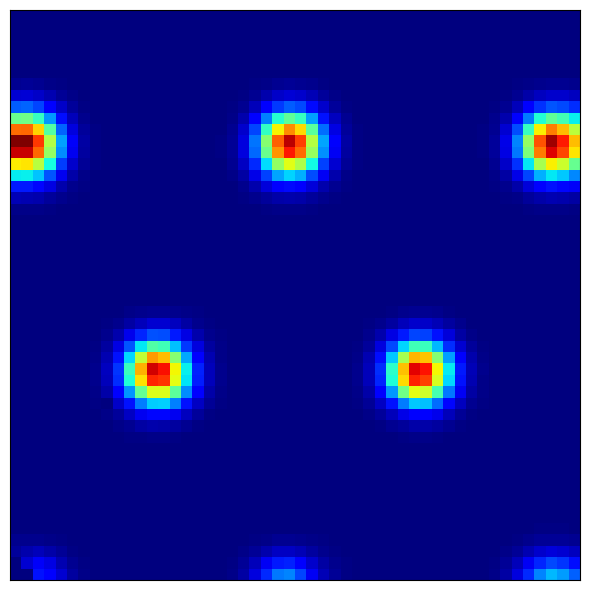

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [9]:
# Reshape to separate modules
heatmaps_grid = heatmaps_grid.reshape(5, -1, M, K)  # (modules, cells, x, y)

# Visualize a grid cell from module 0
module_idx = 0
cell_idx = 42

config = PlotConfig(
    figsize=(6, 6),
    title=f'Grid Cell - Module {module_idx}, Cell {cell_idx}',
    xlabel='X Position (m)',
    ylabel='Y Position (m)',
    show=True,
    save_path=None
)

plot_firing_field_heatmap(
    heatmaps_grid[module_idx, cell_idx],
    config=config
)

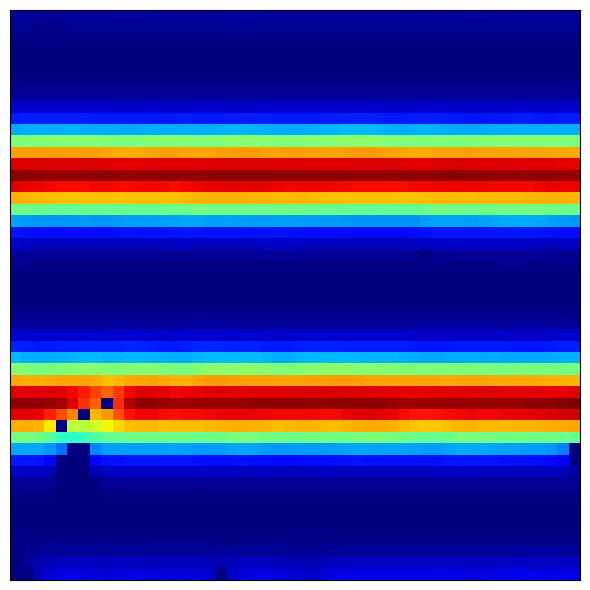

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [10]:
# Reshape band cells
heatmaps_band_x = heatmaps_band_x.reshape(5, -1, M, K)

# Visualize a band cell
config = PlotConfig(
    figsize=(6, 6),
    title=f'Band Cell X - Module {module_idx}, Cell {cell_idx}',
    xlabel='X Position (m)',
    ylabel='Y Position (m)',
    show=True,
    save_path=None
)

plot_firing_field_heatmap(
    heatmaps_band_x[module_idx, cell_idx],
    config=config
)

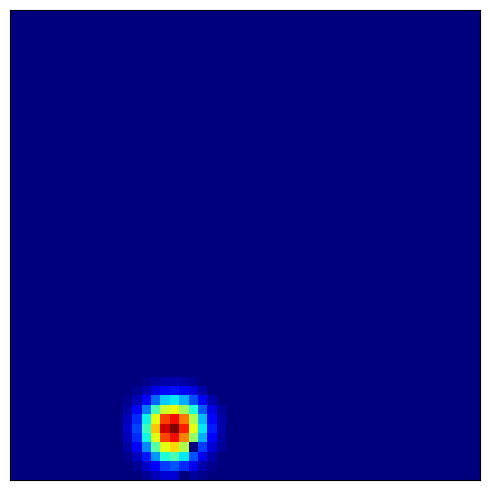

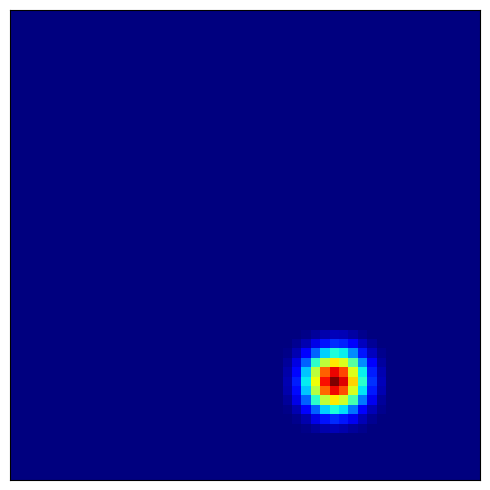

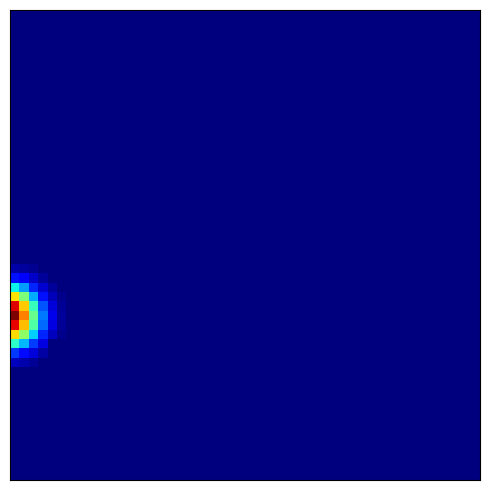

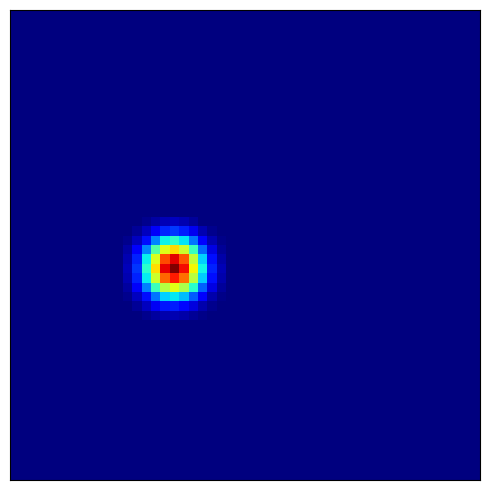

In [11]:
# Visualize several place cells
for place_idx in [100, 200, 300, 400]:
    config = PlotConfig(
        figsize=(5, 5),
        title=f'Place Cell {place_idx}',
        xlabel='X Position (m)',
        ylabel='Y Position (m)',
        show=True,
        save_path=None
    )

    plot_firing_field_heatmap(
        heatmaps_place[place_idx],
        config=config
    )